# Implement the *Neilson hack* using `ws3` and `libcbm`

In this notebook we show how to implement the *Neilson hack* (i.e., generate carbon yield curves from a CBM for use in a forest estate model) using `ws3` and `libcbm`. 

In a nutshell, the *Neilson hack* consists of running a CBM from forest estate model output (see example notebook 030 and 031 for details), except that the inventory table gets hacked to have one record per development type (with age set to 0 and area set to 1) and no disturabance events are simulated. Carbon stock and flux data exported from the CBM can then be reformatted and imported in the forest estate model as carbon yield curves. That is about it. Should work for just about any `ws3` model. See Neilson et al. (2006) for details.

> Neilson, E. T., MacLean, D. A., Arp, P. A., Meng, F. R., Bourque, C. P., & Bhatti, J. S. (2006). Modeling carbon sequestration with CO2Fix and a timber supply model for use in forest management planning. Canadian journal of soil science, 86(Special Issue), 219-233.

In this notebook, we implement the Neilson hack from scratch. In notebook 041 we show how to use built-in `ws3` functions to automate this.

## Set up modelling environment

First, make sure we have the correct versions of `ws3` and `libcbm` installed. Both of these packages are relatively new and under active development, it is best we stick to known-working versions of each package from their respective GitHub repos. 


> We _strongly recommend_ that you run this notebook in venv-sandboxed Python kernel (see `venv_python_kernel_setup` notebook for an example of how to do this). This will ensure that you are working from a fresh Python package environment, and not wasting time debugging random interactions between this notebook and whatever mishmash of packages you have installed on your system in various parts of your Python path. You have been warned. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
install_ws3 = False
install_ws3_localeditable = False
if install_ws3:
    if install_ws3_localeditable: # clobber ws3 installation with local editable copy
        %pip uninstall -y ws3
        %pip install -e ..
    else: # install dev_libcbm branch from ws3 GitHub repo
        %pip install -U git+https://github.com/gparadis/ws3@dev_libcbm
    import ws3
    ws3.__path__

In [3]:
install_libcbm = False
if install_libcbm:
    %pip install -U git+https://github.com/cat-cfs/libcbm_py.git@main
    import libcbm
    libcbm.__path__

Create a `ForestModel` instance by loading Woodstock-formatted input files.

In [4]:
import ws3.forest

In [5]:
base_year = 2020
horizon = 10
period_length = 10
max_age = 1000
tvy_name = 'totvol'

In [6]:
fm = ws3.forest.ForestModel(model_name='tsa24_clipped',
                            model_path='data/woodstock_model_files',
                            base_year=base_year,
                            horizon=horizon,
                            period_length=period_length,
                            max_age=max_age)
fm.import_landscape_section()
fm.import_areas_section()
fm.import_yields_section()
fm.import_actions_section()
fm.import_transitions_section()
fm.initialize_areas()
fm.add_null_action()
fm.reset_actions()

In [7]:
fm.compile_schedule()

[]

Export standard SIT tables from `ws3` as a starting point.

In [8]:
disturbance_type_mapping = [{'user_dist_type': 'harvest', 'default_dist_type': 'Clearcut harvesting without salvage'},
                            {'user_dist_type': 'fire', 'default_dist_type': 'Wildfire'}]

In [9]:
for dtype_key in fm.dtypes:
    fm.dt(dtype_key).last_pass_disturbance = 'fire' if dtype_key[2] == dtype_key[4] else 'harvest'

In [10]:
sit_config, sit_tables = fm.to_cbm_sit(softwood_volume_yname='swdvol', 
                                       hardwood_volume_yname='hwdvol', 
                                       admin_boundary='British Columbia', 
                                       eco_boundary='Montane Cordillera',
                                       disturbance_type_mapping=disturbance_type_mapping)

The `sit_events` table should be empty, because we did not simulate any actions before calling `fm.to_cbm_sit`.

In [11]:
sit_tables['sit_events']

,theme0,theme1,theme2,theme3,theme4,species,using_age_class,min_softwood_age,max_softwood_age,min_hardwood_age,...,MinSWMerchStemSnagC,MaxSWMerchStemSnagC,MinHWMerchStemSnagC,MaxHWMerchStemSnagC,efficiency,sort_type,target_type,target,disturbance_type,disturbance_year


Rebuild the inventory table. We need one inventory record _for every possible development type_ (including system states that are not present in the initial inventory). Conveniently for us, `fm.to_cbm_sit` calls `fm._cbm_sit_yield`, which calls `fm.add_problem`, which calls `fm._bld_tree_m1`, which simulates all feasible combinations of actions, which creates any new development types that we need. You just have to know, and now you can leverage that side-effect to make this next part easy peasy. 

Figuring out which development types were missing and adding them by hand would not have been _too_ difficult for the simple test dataset we are are using here (assuming you are good at reading Woodstock input files and running through all possible future states in your head), but this could be a doozie of a puzzle or larger models with hundreds of initial development types and more complex actions and transitions. Basically, you definitely want to take note of the `add_problem` hack described about and use that. Any other way is just looking for trouble.

We can reuse the `sit_inventory` table returned from `fm.to_cbm_sit` to make sure we have the correct structure.

In [12]:
df = sit_tables['sit_inventory']
df = df.iloc[0:0]
df

,theme0,theme1,theme2,theme3,theme4,species,using_age_class,age,area,delay,landclass,historic_disturbance,last_pass_disturbance


In [13]:
import pandas as pd

In [14]:
data = []
for dtype_key in fm.dtypes:
    dt = fm.dt(dtype_key)
    values = list(dtype_key) 
    values += [dt.leading_species, 'FALSE', 0, 1., 0, 0, 'fire', 'fire' if dtype_key[2] == dtype_key[4] else 'harvest']
    data.append(dict(zip(df.columns, values)))
sit_tables['sit_inventory'] = pd.DataFrame(data)
sit_tables['sit_inventory']

,theme0,theme1,theme2,theme3,theme4,species,using_age_class,age,area,delay,landclass,historic_disturbance,last_pass_disturbance
0,tsa24_clipped,0,2401000,100,2401000,softwood,FALSE,0,1.0,0,0,fire,fire
1,tsa24_clipped,0,2402005,1201,2402005,hardwood,FALSE,0,1.0,0,0,fire,fire
2,tsa24_clipped,1,2401002,204,2401002,softwood,FALSE,0,1.0,0,0,fire,fire
3,tsa24_clipped,1,2401002,204,2421002,softwood,FALSE,0,1.0,0,0,fire,harvest
4,tsa24_clipped,1,2402000,100,2402000,softwood,FALSE,0,1.0,0,0,fire,fire
5,tsa24_clipped,1,2402002,204,2402002,softwood,FALSE,0,1.0,0,0,fire,fire
6,tsa24_clipped,1,2403000,100,2403000,softwood,FALSE,0,1.0,0,0,fire,fire
7,tsa24_clipped,1,2403002,204,2403002,softwood,FALSE,0,1.0,0,0,fire,fire
8,tsa24_clipped,1,2403002,204,2423002,softwood,FALSE,0,1.0,0,0,fire,harvest
9,tsa24_clipped,1,2402000,100,2422000,softwood,FALSE,0,1.0,0,0,fire,harvest


Now we run this thruogh `libcbm` for 300 time steps.

In [15]:
disturbance_type_mapping = [{'user_dist_type': 'harvest', 'default_dist_type': 'Clearcut harvesting without salvage'},
                            {'user_dist_type': 'fire', 'default_dist_type': 'Wildfire'}]

In [16]:
for dtype_key in fm.dtypes:
    fm.dt(dtype_key).last_pass_disturbance = 'fire' if dtype_key[2] == dtype_key[4] else 'harvest'

In [17]:
from util import run_cbm

In [18]:
n_steps = 300
cbm_output = run_cbm(sit_config, sit_tables, n_steps, plot=False)

/media/data/home/gparadis/.virtualenvs/foo/lib/python3.10/site-packages/libcbm/resources/__init__.py:113: RuntimeWarning: unsupported linux distribution: Linux-5.15.0-46-generic-x86_64-with-glibc2.35
  warnings.warn(message, RuntimeWarning)


In [19]:
cbm_output

In [20]:
pi = cbm_output.classifiers.to_pandas().merge(cbm_output.pools.to_pandas(), 
                                              left_on=["identifier", "timestep"], 
                                              right_on=["identifier", "timestep"])
fi = cbm_output.classifiers.to_pandas().merge(cbm_output.flux.to_pandas(), 
                                              left_on=["identifier", "timestep"], 
                                              right_on=["identifier", "timestep"])

In [21]:
pi

,identifier,timestep,theme0,theme1,theme2,theme3,theme4,species,Input,SoftwoodMerch,...,BelowGroundSlowSoil,SoftwoodStemSnag,SoftwoodBranchSnag,HardwoodStemSnag,HardwoodBranchSnag,CO2,CH4,CO,NO2,Products
0,1,0,tsa24_clipped,0,2401000,100,2401000,softwood,1.0,0.000000,...,61.072161,28.616202,19.461734,0.000000,0.000000,4790.526504,4.942348,44.479699,0.0,0.000000
1,2,0,tsa24_clipped,0,2402005,1201,2402005,hardwood,1.0,0.000000,...,114.491754,0.000000,0.000000,65.448939,18.985542,9638.462743,8.550696,76.954017,0.0,0.000000
2,3,0,tsa24_clipped,1,2401002,204,2401002,softwood,1.0,0.000000,...,70.577311,38.209170,20.940326,0.000000,0.000000,5549.131806,5.574412,50.168153,0.0,0.000000
3,4,0,tsa24_clipped,1,2401002,204,2421002,softwood,1.0,0.000000,...,56.591833,0.000000,0.000000,0.000000,0.000000,4504.469208,4.878363,43.903950,0.0,34.110922
4,5,0,tsa24_clipped,1,2402000,100,2402000,softwood,1.0,0.000000,...,78.415619,47.913734,22.404296,0.000000,0.000000,6182.050833,6.060943,54.546827,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3607,8,300,tsa24_clipped,1,2403002,204,2403002,softwood,1.0,63.042997,...,110.566427,10.465389,1.954894,0.000000,0.000000,9088.654777,7.694727,69.250637,0.0,0.000000
3608,9,300,tsa24_clipped,1,2403002,204,2423002,softwood,1.0,92.723531,...,118.471450,9.851096,2.270104,0.000000,0.000000,9070.482693,7.597707,68.377586,0.0,79.633546
3609,10,300,tsa24_clipped,1,2402000,100,2422000,softwood,1.0,74.795270,...,87.528498,7.785973,2.065819,0.000000,0.000000,6201.980905,5.599995,50.398516,0.0,48.597173
3610,11,300,tsa24_clipped,1,2402002,204,2422002,softwood,1.0,66.253514,...,93.752506,6.990460,1.970435,0.000000,0.000000,6923.626178,6.063782,54.572506,0.0,53.757580


In [22]:
pi.columns

Index(['identifier', 'timestep', 'theme0', 'theme1', 'theme2', 'theme3',
       'theme4', 'species', 'Input', 'SoftwoodMerch', 'SoftwoodFoliage',
       'SoftwoodOther', 'SoftwoodCoarseRoots', 'SoftwoodFineRoots',
       'HardwoodMerch', 'HardwoodFoliage', 'HardwoodOther',
       'HardwoodCoarseRoots', 'HardwoodFineRoots', 'AboveGroundVeryFastSoil',
       'BelowGroundVeryFastSoil', 'AboveGroundFastSoil', 'BelowGroundFastSoil',
       'MediumSoil', 'AboveGroundSlowSoil', 'BelowGroundSlowSoil',
       'SoftwoodStemSnag', 'SoftwoodBranchSnag', 'HardwoodStemSnag',
       'HardwoodBranchSnag', 'CO2', 'CH4', 'CO', 'NO2', 'Products'],
      dtype='object')

In [23]:
fi

,identifier,timestep,theme0,theme1,theme2,theme3,theme4,species,DisturbanceCO2Production,DisturbanceCH4Production,...,DisturbanceVFastBGToAir,DisturbanceFastAGToAir,DisturbanceFastBGToAir,DisturbanceMediumToAir,DisturbanceSlowAGToAir,DisturbanceSlowBGToAir,DisturbanceSWStemSnagToAir,DisturbanceSWBranchSnagToAir,DisturbanceHWStemSnagToAir,DisturbanceHWBranchSnagToAir
0,1,0,tsa24_clipped,0,2401000,100,2401000,softwood,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,0,tsa24_clipped,0,2402005,1201,2402005,hardwood,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,0,tsa24_clipped,1,2401002,204,2401002,softwood,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,0,tsa24_clipped,1,2401002,204,2421002,softwood,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,0,tsa24_clipped,1,2402000,100,2402000,softwood,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3607,8,300,tsa24_clipped,1,2403002,204,2403002,softwood,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3608,9,300,tsa24_clipped,1,2403002,204,2423002,softwood,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3609,10,300,tsa24_clipped,1,2402000,100,2422000,softwood,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3610,11,300,tsa24_clipped,1,2402002,204,2422002,softwood,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
fi.columns

Index(['identifier', 'timestep', 'theme0', 'theme1', 'theme2', 'theme3',
       'theme4', 'species', 'DisturbanceCO2Production',
       'DisturbanceCH4Production', 'DisturbanceCOProduction',
       'DisturbanceBioCO2Emission', 'DisturbanceBioCH4Emission',
       'DisturbanceBioCOEmission', 'DecayDOMCO2Emission',
       'DisturbanceSoftProduction', 'DisturbanceHardProduction',
       'DisturbanceDOMProduction', 'DeltaBiomass_AG', 'DeltaBiomass_BG',
       'TurnoverMerchLitterInput', 'TurnoverFolLitterInput',
       'TurnoverOthLitterInput', 'TurnoverCoarseLitterInput',
       'TurnoverFineLitterInput', 'DecayVFastAGToAir', 'DecayVFastBGToAir',
       'DecayFastAGToAir', 'DecayFastBGToAir', 'DecayMediumToAir',
       'DecaySlowAGToAir', 'DecaySlowBGToAir', 'DecaySWStemSnagToAir',
       'DecaySWBranchSnagToAir', 'DecayHWStemSnagToAir',
       'DecayHWBranchSnagToAir', 'DisturbanceMerchToAir',
       'DisturbanceFolToAir', 'DisturbanceOthToAir', 'DisturbanceCoarseToAir',
       'Disturban

Now we just need to recompile this data into yield curves and stuff them back into our `ForestModel` instance.

In [25]:
biomass_pools = ['SoftwoodMerch','SoftwoodFoliage', 'SoftwoodOther', 'SoftwoodCoarseRoots','SoftwoodFineRoots',                        
                 'HardwoodMerch', 'HardwoodFoliage', 'HardwoodOther', 'HardwoodCoarseRoots', 'HardwoodFineRoots']
dom_pools = ['AboveGroundVeryFastSoil', 'BelowGroundVeryFastSoil', 'AboveGroundFastSoil', 'BelowGroundFastSoil',
             'MediumSoil', 'AboveGroundSlowSoil', 'BelowGroundSlowSoil', 'SoftwoodStemSnag', 'SoftwoodBranchSnag',
             'HardwoodStemSnag', 'HardwoodBranchSnag']
emissions_pools = ['CO2', 'CH4', 'CO', 'NO2']
products_pools = ['Products']
ecosystem_pools = biomass_pools + dom_pools
all_pools = biomass_pools + dom_pools + emissions_pools + products_pools

In [128]:
annual_process_fluxes = [
    'DecayDOMCO2Emission',
    'DeltaBiomass_AG',
    'DeltaBiomass_BG',
    'TurnoverMerchLitterInput',
    'TurnoverFolLitterInput',
    'TurnoverOthLitterInput',
    'TurnoverCoarseLitterInput',
    'TurnoverFineLitterInput',
    'DecayVFastAGToAir',
    'DecayVFastBGToAir',
    'DecayFastAGToAir',
    'DecayFastBGToAir',
    'DecayMediumToAir',
    'DecaySlowAGToAir',
    'DecaySlowBGToAir',
    'DecaySWStemSnagToAir',
    'DecaySWBranchSnagToAir',
    'DecayHWStemSnagToAir',
    'DecayHWBranchSnagToAir'
]

npp_fluxes=[
    'DeltaBiomass_AG', 
    'DeltaBiomass_BG'
]
decay_emissions_fluxes = [
    'DecayVFastAGToAir',
    'DecayVFastBGToAir',
    'DecayFastAGToAir',
    'DecayFastBGToAir',
    'DecayMediumToAir',
    'DecaySlowAGToAir',
    'DecaySlowBGToAir',
    'DecaySWStemSnagToAir',
    'DecaySWBranchSnagToAir',
    'DecayHWStemSnagToAir',
    'DecayHWBranchSnagToAir'
]

disturbance_production_fluxes = [
    'DisturbanceSoftProduction',
    'DisturbanceHardProduction',
    'DisturbanceDOMProduction'   
]

disturbance_emissions_fluxes = [
    'DisturbanceMerchToAir',
    'DisturbanceFolToAir',
    'DisturbanceOthToAir',
    'DisturbanceCoarseToAir',
    'DisturbanceFineToAir',
    'DisturbanceVFastAGToAir',
    'DisturbanceVFastBGToAir',
    'DisturbanceFastAGToAir',
    'DisturbanceFastBGToAir',
    'DisturbanceMediumToAir',
    'DisturbanceSlowAGToAir',
    'DisturbanceSlowBGToAir',
    'DisturbanceSWStemSnagToAir',
    'DisturbanceSWBranchSnagToAir',
    'DisturbanceHWStemSnagToAir',
    'DisturbanceHWBranchSnagToAir'   
]

all_fluxes = [
    'DisturbanceCO2Production',
    'DisturbanceCH4Production',
    'DisturbanceCOProduction',
    'DisturbanceBioCO2Emission',
    'DisturbanceBioCH4Emission',
    'DisturbanceBioCOEmission',
    'DecayDOMCO2Emission',
    'DisturbanceSoftProduction',
    'DisturbanceHardProduction',
    'DisturbanceDOMProduction',
    'DeltaBiomass_AG',
    'DeltaBiomass_BG',
    'TurnoverMerchLitterInput',
    'TurnoverFolLitterInput',
    'TurnoverOthLitterInput',
    'TurnoverCoarseLitterInput',
    'TurnoverFineLitterInput',
    'DecayVFastAGToAir',
    'DecayVFastBGToAir',
    'DecayFastAGToAir',
    'DecayFastBGToAir',
    'DecayMediumToAir',
    'DecaySlowAGToAir',
    'DecaySlowBGToAir',
    'DecaySWStemSnagToAir',
    'DecaySWBranchSnagToAir',
    'DecayHWStemSnagToAir',
    'DecayHWBranchSnagToAir',
    'DisturbanceMerchToAir',
    'DisturbanceFolToAir',
    'DisturbanceOthToAir',
    'DisturbanceCoarseToAir',
    'DisturbanceFineToAir',
    'DisturbanceDOMCO2Emission',
    'DisturbanceDOMCH4Emission',
    'DisturbanceDOMCOEmission',
    'DisturbanceMerchLitterInput',
    'DisturbanceFolLitterInput',
    'DisturbanceOthLitterInput',
    'DisturbanceCoarseLitterInput',
    'DisturbanceFineLitterInput',
    'DisturbanceVFastAGToAir',
    'DisturbanceVFastBGToAir',
    'DisturbanceFastAGToAir',
    'DisturbanceFastBGToAir',
    'DisturbanceMediumToAir',
    'DisturbanceSlowAGToAir',
    'DisturbanceSlowBGToAir',
    'DisturbanceSWStemSnagToAir',
    'DisturbanceSWBranchSnagToAir',
    'DisturbanceHWStemSnagToAir',
    'DisturbanceHWBranchSnagToAir'
]

In [27]:
pi['dtype_key'] = pi.apply(lambda r: '%s %s %s %s %s' % (r['theme0'], r['theme1'], r['theme2'], r['theme3'], r['theme4']), axis=1)
fi['dtype_key'] = fi.apply(lambda r: '%s %s %s %s %s' % (r['theme0'], r['theme1'], r['theme2'], r['theme3'], r['theme4']), axis=1)

In [28]:
pi_gb_sum = pi.groupby(['dtype_key', 'timestep'], as_index=True)[all_pools].sum()
fi_gb_sum = fi.groupby(['dtype_key', 'timestep'], as_index=True)[all_fluxes].sum()

Reformatted this way, we essentially have carbon yield curves now.

In [29]:
pi_gb_sum

SoftwoodMerch  SoftwoodFoliage  \
dtype_key                           timestep                                   
tsa24_clipped 0 2401000 100 2401000 0              0.000000         0.000000   
                                    1              0.000036         0.132721   
                                    2              0.000305         0.370208   
                                    3              0.001061         0.611266   
                                    4              0.002569         0.774699   
...                                                     ...              ...   
tsa24_clipped 1 2403002 204 2423002 296           92.723531         8.635211   
                                    297           92.723531         8.635211   
                                    298           92.723531         8.635211   
                                    299           92.723531         8.635211   
                                    300           92.723531         8.635211   

                                              SoftwoodOther  \
dtype_key                           timestep                  
tsa24_clipped 0 2401000 100 2401000 0              0.000000   
                                    1              0.000000   
                                    2              0.000000   
                                    3              0.061592   
                                    4              0.251065   
...                                                     ...   
tsa24_clipped 1 2403002 204 2423002 296           32.241928   
                                    297           32.241928   
                                    298           32.241928   
                                    299           32.241928   
                                    300           32.241928   

                                              SoftwoodCoarseRoots  \
dtype_key                           timestep                        
tsa24_clipped 0 2401000 100 2401000 0                    0.000000   
                                    1                    0.016954   
                                    2                    0.047501   
                                    3                    0.086822   
                                    4                    0.133230   
...                                                           ...   
tsa24_clipped 1 2403002 204 2423002 296                 27.228756   
                                    297                 27.228756   
                                    298                 27.228756   
                                    299                 27.228756   
                                    300                 27.228756   

                                              SoftwoodFineRoots  \
dtype_key                           timestep                      
tsa24_clipped 0 2401000 100 2401000 0                  0.000000   
                                    1                  0.012518   
                                    2                  0.034753   
                                    3                  0.062788   
                                    4                  0.095060   
...                                                         ...   
tsa24_clipped 1 2403002 204 2423002 296                2.430592   
                                    297                2.430592   
                                    298                2.430592   
                                    299                2.430592   
                                    300                2.430592   

                                              HardwoodMerch  HardwoodFoliage  \
dtype_key                           timestep                                   
tsa24_clipped 0 2401000 100 2401000 0                   0.0              0.0   
                                    1                   0.0              0.0   
                                    2                   0.0              0.0   
               

In [30]:
fi_gb_sum

DisturbanceCO2Production  \
dtype_key                           timestep                             
tsa24_clipped 0 2401000 100 2401000 0                              0.0   
                                    1                              0.0   
                                    2                              0.0   
                                    3                              0.0   
                                    4                              0.0   
...                                                                ...   
tsa24_clipped 1 2403002 204 2423002 296                            0.0   
                                    297                            0.0   
                                    298                            0.0   
                                    299                            0.0   
                                    300                            0.0   

                                              DisturbanceCH4Production  \
dtype_key                           timestep                             
tsa24_clipped 0 2401000 100 2401000 0                              0.0   
                                    1                              0.0   
                                    2                              0.0   
                                    3                              0.0   
                                    4                              0.0   
...                                                                ...   
tsa24_clipped 1 2403002 204 2423002 296                            0.0   
                                    297                            0.0   
                                    298                            0.0   
                                    299                            0.0   
                                    300                            0.0   

                                              DisturbanceCOProduction  \
dtype_key                           timestep                            
tsa24_clipped 0 2401000 100 2401000 0                             0.0   
                                    1                             0.0   
                                    2                             0.0   
                                    3                             0.0   
                                    4                             0.0   
...                                                               ...   
tsa24_clipped 1 2403002 204 2423002 296                           0.0   
                                    297                           0.0   
                                    298                           0.0   
                                    299                           0.0   
                                    300                           0.0   

                                              DisturbanceBioCO2Emission  \
dtype_key                           timestep                              
tsa24_clipped 0 2401000 100 2401000 0                               0.0   
                                    1                               0.0   
                                    2                               0.0   
                                    3                               0.0   
                                    4                               0.0   
...                                                                 ...   
tsa24_clipped 1 2403002 204 2423002 296                             0.0   
                                    297                             0.0   
                                    298                             0.0   
                                    299                             0.0   
                                    300                             0.0   

                                              DisturbanceBioCH4Emission  \
dtype_key                           timestep                              
tsa24_clipped 0 2401000 100 2401000 0       

Add carbon yield curves to our model.

In [31]:
for dtype_key in fm.dtypes:
    dt = fm.dt(dtype_key)
    mask = ('?', '?', dtype_key[2], '?', dtype_key[4])
    for _mask, ytype, curves in fm.yields:
        if _mask != mask: continue # we know there will be a match so this works
        print('found match for mask', mask)
        pool_data = pi_gb_sum.loc[' '.join(dtype_key)]
        for yname in all_pools:
            points = list(zip(pool_data.index.values, pool_data[yname]))
            curve = fm.register_curve(ws3.core.Curve(yname, 
                                                     points=points, 
                                                     type='a', 
                                                     is_volume=False,
                                                     xmax=fm.max_age,
                                                     period_length=fm.period_length))
            curves.append((yname, curve))
            dt.add_ycomp('a', yname, curve)
        flux_data = fi_gb_sum.loc[' '.join(dtype_key)]
        for yname in all_fluxes:
            points = list(zip(flux_data.index.values, flux_data[yname]))
            curve = fm.register_curve(ws3.core.Curve(yname, 
                                                     points=points, 
                                                     type='a', 
                                                     is_volume=False,
                                                     xmax=fm.max_age,
                                                     period_length=fm.period_length))
            curves.append((yname, curve))
            dt.add_ycomp('a', yname, curve)
    #mask = '? ? %s ? %' % (dtype_key[2], dtype_key[4])
    #points = pi_gb_sum

found match for mask ('?', '?', '2401000', '?', '2401000')
found match for mask ('?', '?', '2401000', '?', '2401000')
found match for mask ('?', '?', '2402005', '?', '2402005')
found match for mask ('?', '?', '2402005', '?', '2402005')
found match for mask ('?', '?', '2401002', '?', '2401002')
found match for mask ('?', '?', '2401002', '?', '2421002')
found match for mask ('?', '?', '2402000', '?', '2402000')
found match for mask ('?', '?', '2402002', '?', '2402002')
found match for mask ('?', '?', '2403000', '?', '2403000')
found match for mask ('?', '?', '2403002', '?', '2403002')
found match for mask ('?', '?', '2403002', '?', '2423002')
found match for mask ('?', '?', '2402000', '?', '2422000')
found match for mask ('?', '?', '2402002', '?', '2422002')
found match for mask ('?', '?', '2403000', '?', '2423000')


In [32]:
fm.reset()

In [33]:
fm.grow()

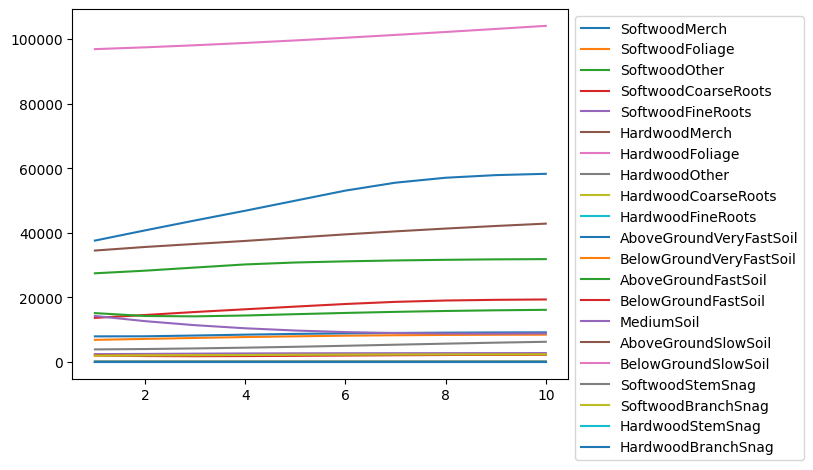

In [34]:
import matplotlib.pyplot as plt
for pool in ecosystem_pools: 
    x, y = fm.periods, [fm.inventory(p, pool) for p in fm.periods]
    plt.plot(x, y, label=pool)
plt.legend(bbox_to_anchor=(1, 1))

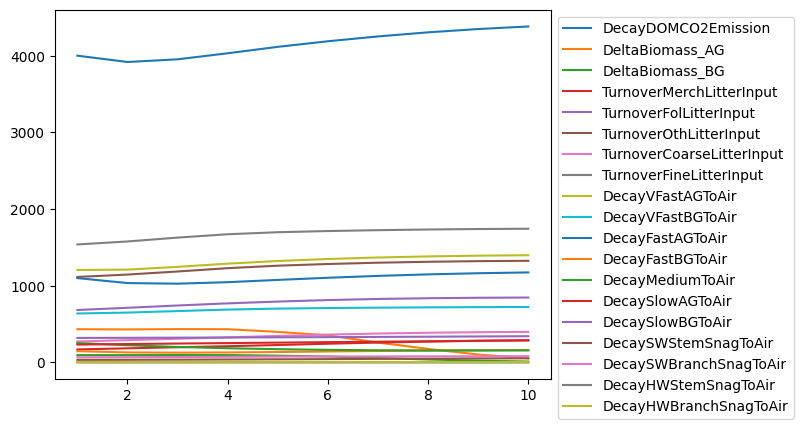

In [35]:
import matplotlib.pyplot as plt
for flux in annual_process_fluxes:
    x, y = fm.periods, [fm.inventory(p, flux) for p in fm.periods]
    plt.plot(x, y, label=flux)
plt.legend(bbox_to_anchor=(1, 1))

Not the most pretty or informative plots, but the point is that we are new tracking 26 new carbon pools and 52 new carbon fluxes in our model. 

Bam!

To make this more useful in a production model, we would likely also want to define some complex yields that aggregate groups of pools and fluxes, and then use these aggregate indicators either as part of the objective function or constraints of an optimization model (i.e., to include carbon in management strategy) or simply as an output indicator (i.e., for reporting on scenario performance without directly influencing the management strategy). 

## Compare embedded carbon anticipation function to original CBM model

The new `ws3` embedded carbon anticipation function is a simplified version of the original CBM model, so we expect it will produce highly correlated but somewhat offset results from the original `libcbm` model.

We can verify this by comparing carbon output from both models side-by-side.

We start by defining a utility function that runs `libcbm`, compiles `libcbm` and `ws3` carbon pool and flux data into analogous tables, and plots results.

In [526]:
def compare_ws3_cbm(pools=biomass_pools, fluxes=annual_process_fluxes, 
                    cbm_x_shift=False, 
                    ws3_pool_coeff=1., ws3_flux_coeff=1.,
                    ws3_pool_const=0., ws3_flux_const=0.):
    sit_config, sit_tables = fm.to_cbm_sit(softwood_volume_yname='swdvol', 
                                           hardwood_volume_yname='hwdvol', 
                                           admin_boundary='British Columbia', 
                                           eco_boundary='Montane Cordillera',
                                           disturbance_type_mapping=disturbance_type_mapping)
    n_steps = 100
    cbm_output = run_cbm(sit_config, sit_tables, n_steps, plot=False)
    pi = cbm_output.classifiers.to_pandas().merge(cbm_output.pools.to_pandas(), 
                                                  left_on=["identifier", "timestep"], 
                                                  right_on=["identifier", "timestep"])
    fi = cbm_output.classifiers.to_pandas().merge(cbm_output.flux.to_pandas(), 
                                                  left_on=["identifier", "timestep"], 
                                                  right_on=["identifier", "timestep"])
    if cbm_x_shift:
        df_cbm = pd.DataFrame({'period':pi['timestep'] * 0.1, 
                           'pool':pi[pools].sum(axis=1),
                           'flux':fi[fluxes].sum(axis=1)}).groupby('period').sum().iloc[1::10, :].reset_index()
        df_cbm['period'] = (df_cbm['period'] - 0.1 + 1.0).astype(int)
    else:
        df_cbm = pd.DataFrame({'period':pi['timestep'] * 0.1, 
                           'pool':pi[pools].sum(axis=1),
                           'flux':fi[fluxes].sum(axis=1)}).groupby('period').sum().iloc[10::10, :].reset_index()
        df_cbm['period'] = (df_cbm['period']).astype(int)

    df_ws3 = pd.DataFrame({'period':fm.periods,
                           'pool':[sum(fm.inventory(period, pool) for pool in pools) for period in fm.periods],
                           'flux':[sum(fm.inventory(period, flux) for flux in fluxes) for period in fm.periods],
                           'ha':[fm.compile_product(period, '1.', acode='harvest') for period in fm.periods]})
    fix, ax = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
    ax[0].plot(df_cbm['period'], df_cbm['pool'], label='cbm pool')
    ax[0].plot(df_ws3['period'], df_ws3['pool'] * ws3_pool_coeff + ws3_pool_const, label='ws3 pool')
    ax[1].plot(df_cbm['period'], df_cbm['flux'], label='cbm flux')
    ax[1].plot(df_ws3['period'], df_ws3['flux'] * ws3_flux_coeff + ws3_flux_const, label='ws3 flux')
    ax[0].legend()
    ax[1].legend()
    ax[0].set_ylim(0, None)
    ax[1].set_ylim(0, None)
    return pi, fi, df_ws3, df_cbm

First we run a no-disturbance scenario (i.e., just growth). This should almost perfectly match what we ran through the CBM in the first place to create the carbon yield curves, so we expect there should be a very close match between `ws3` and `libcbm` output for both stocks and fluxes.

In [527]:
from util import compile_scenario, plot_scenario

In [653]:
fm.reset()
fm.grow()

(<Figure size 1200x400 with 3 Axes>,
 array([<Axes: title={'center': 'Harvested area (ha)'}>,
        <Axes: title={'center': 'Harvested volume (m3)'}>,
        <Axes: title={'center': 'Growing Stock (m3)'}>], dtype=object))

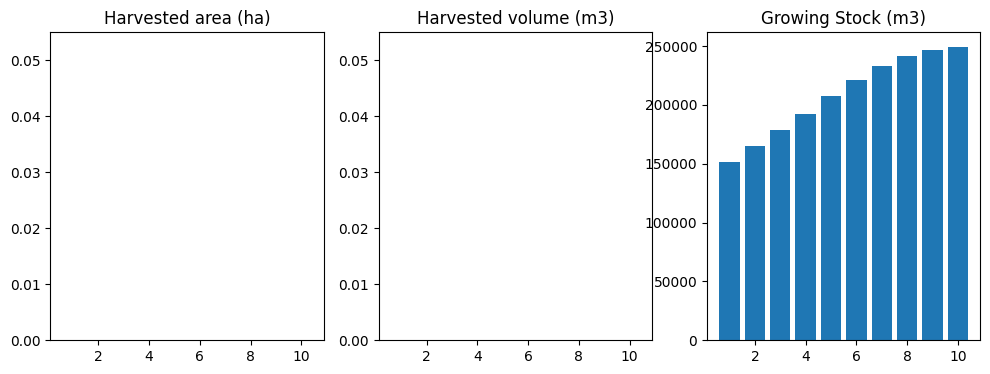

In [654]:
df = compile_scenario(fm)
plot_scenario(df)

In [655]:
pools = biomass_pools + dom_pools + products_pools
#fluxes = npp_fluxes + decay_emissions_fluxes + disturbance_emissions_fluxes + disturbance_production_fluxes 
#fluxes = npp_fluxes + disturbance_production_fluxes 
#fluxes = ['DecayDOMCO2Emission']
fluxes = decay_emissions_fluxes

#pools = all_pools
#fluxes = all_fluxes

/media/data/home/gparadis/.virtualenvs/foo/lib/python3.10/site-packages/libcbm/resources/__init__.py:113: RuntimeWarning: unsupported linux distribution: Linux-5.15.0-46-generic-x86_64-with-glibc2.35
  warnings.warn(message, RuntimeWarning)


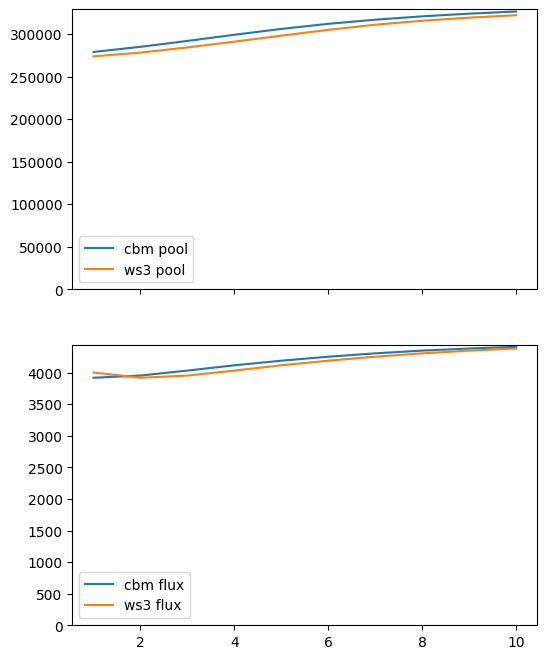

In [656]:
pi, fi, df_ws3, df_cbm = compare_ws3_cbm(pools=pools, fluxes=fluxes)

Looks pretty good!

Next, simulate some harvesting. 

Next, we use the `schedule_harvest_areacontrol` function defined in the local `util` module to simulate some harvesting in all periods. We expect there will be more of a gap between `ws3` and `libcbm` carbon estimates, although we still expect `ws3` output to be highly correlated with `libcbm`. 

In [657]:
fm.reset()

In [658]:
from util import schedule_harvest_areacontrol

In [659]:
sch = schedule_harvest_areacontrol(fm)

(<Figure size 1200x400 with 3 Axes>,
 array([<Axes: title={'center': 'Harvested area (ha)'}>,
        <Axes: title={'center': 'Harvested volume (m3)'}>,
        <Axes: title={'center': 'Growing Stock (m3)'}>], dtype=object))

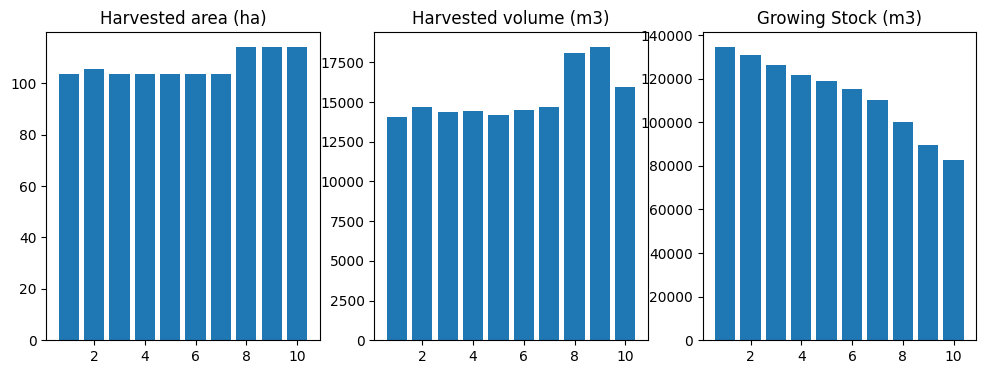

In [660]:
df = compile_scenario(fm)
plot_scenario(df)

/media/data/home/gparadis/.virtualenvs/foo/lib/python3.10/site-packages/libcbm/resources/__init__.py:113: RuntimeWarning: unsupported linux distribution: Linux-5.15.0-46-generic-x86_64-with-glibc2.35
  warnings.warn(message, RuntimeWarning)


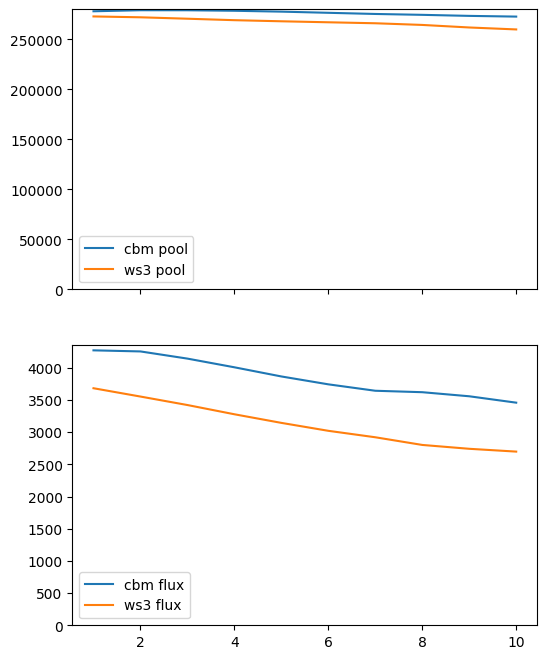

In [661]:
pi, fi, df_ws3, df_cbm = compare_ws3_cbm(pools=pools, fluxes=fluxes)

As expected, when we include harvesting disturbances in our simulation `ws3` carbon indicators diverge from corresponding `libcbm` indicators. The gaps for stocks and fluxes are substantial (and of different magnitudes), but output from both models is hightly correlated. So even with some estimations error, we could likely still use these carbon indicators to define optimization problems in `ws3` and get a useful response from the model.

In [662]:
df_ws3

,period,pool,flux,ha
0,1,273038.224079,3684.318154,103.411088
1,2,272183.317438,3555.014049,105.655079
2,3,270757.425489,3423.239007,103.411088
3,4,269290.984414,3279.680491,103.411088
4,5,268189.415203,3145.807922,103.411088
5,6,267189.591266,3022.501985,103.411088
6,7,266209.886837,2922.140693,103.411088
7,8,264538.269595,2802.888808,114.043292
8,9,261988.973856,2742.978337,114.043292
9,10,260038.625703,2699.396679,114.043292


In [663]:
pool_corr = (df_cbm['pool'] / df_ws3['pool']).mean()
pool_corr

1.0349424535173106

In [664]:
flux_corr = ((df_cbm['flux'] - df_ws3['flux']) / df_ws3['ha']).mean()
flux_corr

6.833749380341729

Apply correction.

/media/data/home/gparadis/.virtualenvs/foo/lib/python3.10/site-packages/libcbm/resources/__init__.py:113: RuntimeWarning: unsupported linux distribution: Linux-5.15.0-46-generic-x86_64-with-glibc2.35
  warnings.warn(message, RuntimeWarning)


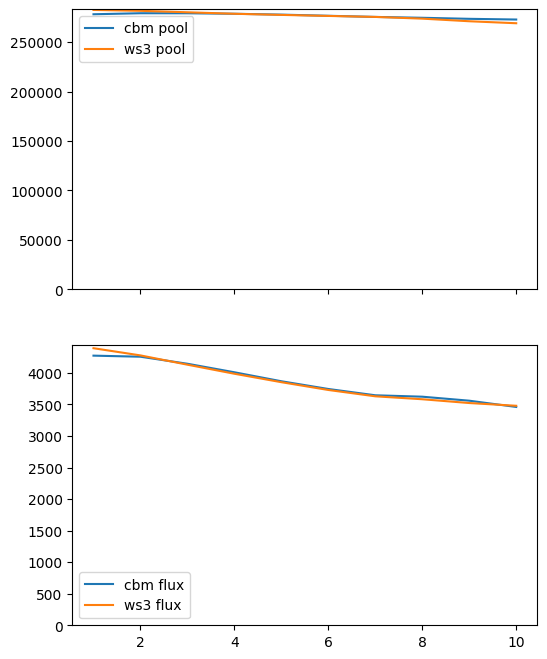

In [665]:
pi, fi, df_ws3, df_cbm = compare_ws3_cbm(pools=pools, fluxes=fluxes,
                                         ws3_pool_coeff=pool_corr,
                                         ws3_flux_const=flux_corr*df_ws3['ha'])

Looking good!

Schedule some more harvesting on top of previous solution, to see how stable the gaps are. Not super important what the exact harvest pattern is here, as long as it is distinct from the previous scenario.

In [666]:
sch = schedule_harvest_areacontrol(fm)

(<Figure size 1200x400 with 3 Axes>,
 array([<Axes: title={'center': 'Harvested area (ha)'}>,
        <Axes: title={'center': 'Harvested volume (m3)'}>,
        <Axes: title={'center': 'Growing Stock (m3)'}>], dtype=object))

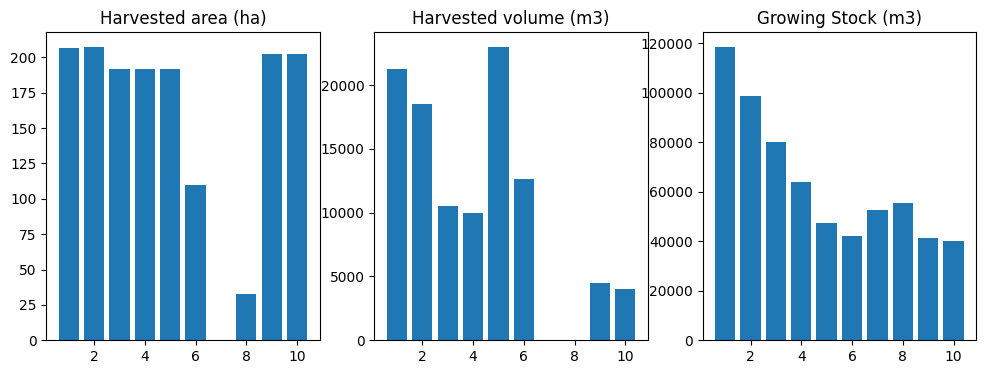

In [667]:
df = compile_scenario(fm)
plot_scenario(df)

No correction.

/media/data/home/gparadis/.virtualenvs/foo/lib/python3.10/site-packages/libcbm/resources/__init__.py:113: RuntimeWarning: unsupported linux distribution: Linux-5.15.0-46-generic-x86_64-with-glibc2.35
  warnings.warn(message, RuntimeWarning)


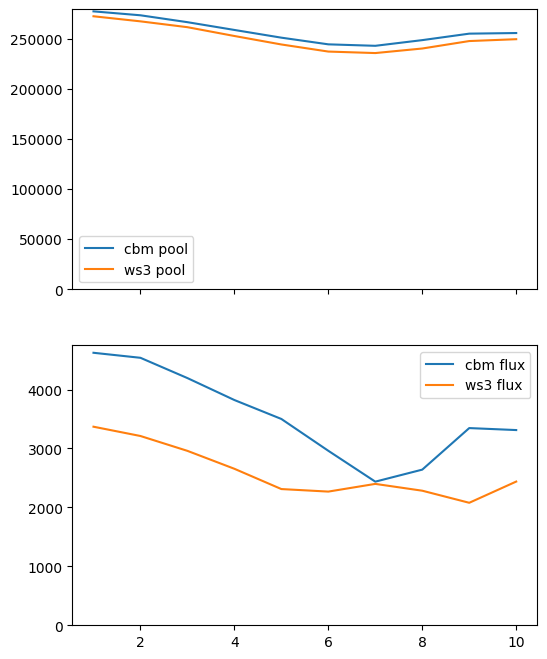

In [668]:
pi, fi, df_ws3, df_cbm = compare_ws3_cbm(pools=pools, fluxes=fluxes)

With correction.

/media/data/home/gparadis/.virtualenvs/foo/lib/python3.10/site-packages/libcbm/resources/__init__.py:113: RuntimeWarning: unsupported linux distribution: Linux-5.15.0-46-generic-x86_64-with-glibc2.35
  warnings.warn(message, RuntimeWarning)


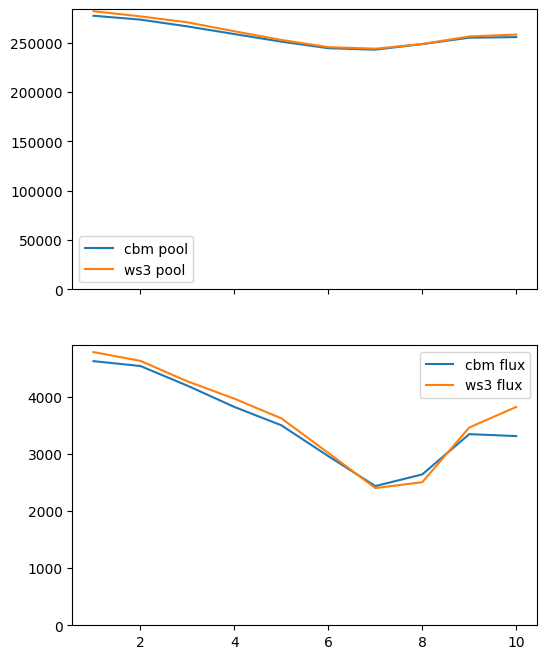

In [675]:
pi, fi, df_ws3, df_cbm = compare_ws3_cbm(pools=pools, fluxes=fluxes,
                                         ws3_pool_coeff=pool_corr,
                                         ws3_flux_const=flux_corr*df_ws3['ha'])

Very nice! Now try again with more harvesting, to test stability of the correction hack.

In [676]:
sch = schedule_harvest_areacontrol(fm)

(<Figure size 1200x400 with 3 Axes>,
 array([<Axes: title={'center': 'Harvested area (ha)'}>,
        <Axes: title={'center': 'Harvested volume (m3)'}>,
        <Axes: title={'center': 'Growing Stock (m3)'}>], dtype=object))

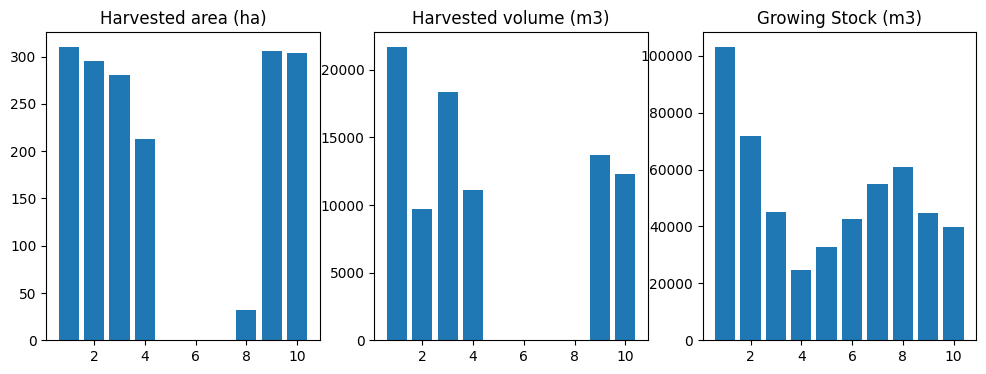

In [677]:
df = compile_scenario(fm)
plot_scenario(df)

No correction.

/media/data/home/gparadis/.virtualenvs/foo/lib/python3.10/site-packages/libcbm/resources/__init__.py:113: RuntimeWarning: unsupported linux distribution: Linux-5.15.0-46-generic-x86_64-with-glibc2.35
  warnings.warn(message, RuntimeWarning)


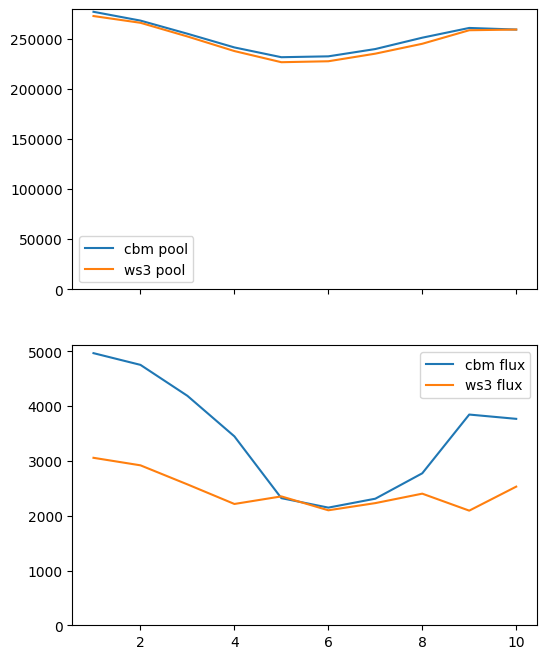

In [678]:
pi, fi, df_ws3, df_cbm = compare_ws3_cbm(pools=pools, fluxes=fluxes)

With correction.

/media/data/home/gparadis/.virtualenvs/foo/lib/python3.10/site-packages/libcbm/resources/__init__.py:113: RuntimeWarning: unsupported linux distribution: Linux-5.15.0-46-generic-x86_64-with-glibc2.35
  warnings.warn(message, RuntimeWarning)


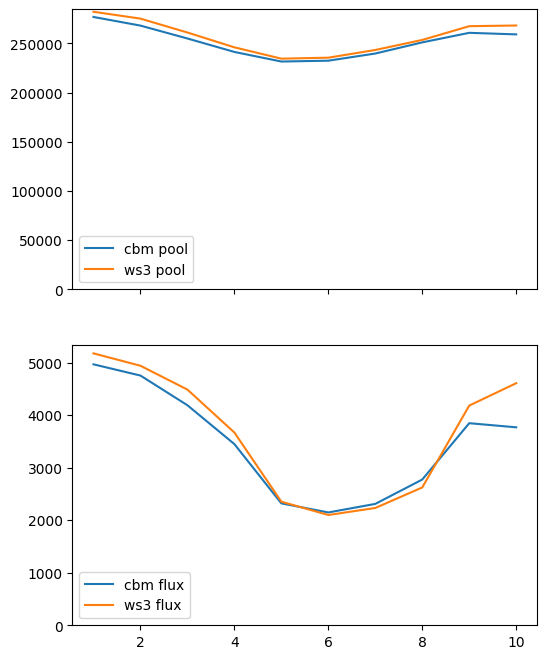

In [679]:
pi, fi, df_ws3, df_cbm = compare_ws3_cbm(pools=pools, fluxes=fluxes,
                                         ws3_pool_coeff=pool_corr,
                                         ws3_flux_const=flux_corr*df_ws3['ha'])

Note that this correction hack is *not* guaranteed to work for all datasets, but might constitute a good start if you want to apply develop a single correction hack that could be applied to all carbon and flux indicators in your `ws3` model (across all scenarios). The way we implemented this would work reasonably well as a _post hoc_ correction on `ws3` model output (e.g., for reporting), but does not correct the carbon indicators inside the model (so they would still be a bit wonky and might distort harvesting solutions, e.g., if we included one or more wonky carbon indicators in an optimization problem).
 
You could easily implement a similar pool correction inside `ws3` by scaling all carbon pool yield curves by an appropriate coefficient. 

The correction we applied to the flux estimates would be less intuitive to implement. To implement this correction inside an optimizaiton problem, you would likely have to define the appropriate `coeff_func` function to return something like $x + (Cxy)$, where $x$ is something like `fm.inventory(..., yname='flux_yname', ...)`, $y$ is something like `(fm.compile_product(..., expr='1.', acode='harvest', ...)` and $C$ is the flux correction coefficient (calculated similary to how we did it above, but then divided by the total system flux in `ws3`). Might get a bit messy, and may not be necessary at all depending on what you are trying to do (and why).

The _post hoc_ calibration should work well enough for reporting purposes (or to confirm that "optimizing" for carbon in a `ws3` scenario actually did more good than harm, which is not a given).